<a href="https://colab.research.google.com/github/JordanHoffmann3/Sim1ab/blob/master/Sim1_31Dec2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''                                                                   
Simulation of Particle Motion in lane with sinusoidal walls

This Python program simulates the flow of an arbitrary number of 
non-interacting particles in a conservative lane with sinusoidal walls.

Program written by Alec Lau with Martin Storey and Jordan Hoffmann 
in 2020.
Last Modified Dec-07, 2020 (Jordan Hoffmann)

Reference article: 
    A simulation of particle motion in a lane with sinusoidal walls
    Martin Storey and Alec Lau, 2020. 
    ArXiv xxx.xxx.xxx (in preparation)

Program overview:
    1. Run the specified number of simulations, adding them to the  
        previous simulation runs for the same set of parameters, if 
        applicable.
    2. Display a sample trajectory from that series, the very last one. 
    3. Do a statistical analysis of all the runs done for this set of 
        parameters, i.e. this series of runs and every previous one 
        found in the data file; present some of the results graphically. 

Output:
    - A simulation data file accumulating all the simulation results  
    for this set of simulation parameters.
    - An analysis data file containing the average velocity data at  
    the regular time-sampling specified.
    - Some figures

To run:
    1. Execute the code cell first, which contains all of the main 
        code; at the bottom of the cell, follow the link to obtain a 
        password, enter the password and press <return>
    2. After setting or verifying the simulation parameters, 
        execute the main program cell.

In addition to the figures that appear, output files are available by
clicking on the folder icon on the left hand side of the Colab window. 

Main parameters:
Lane geometry:
    wall_wavelength = S in the article       
    wall_amplitude = A in the article
    avg_lane_radius = Z0 in the article
Particle initialisation:
    init_flow_vel = Vflow in the article
    vel_variance = sigma^2 in the article
Simulation:
    single_run_duration = T in the article
    num_sim_runs = N in the article
    precision = an indication of the precision of each collision point
Visualisation:
    num_histogram_bins
    num_time_ints = 100        

'''

You are simulating the trajectory of 1 non-interacting particles.
Wall wavelength: 1.0 & amplitude: 0.5
Wall sinusoidal amplitude: 0.5 units of length
Lane average half-radius: 2.0 units of length
Simulation run duration: 10 units of time
Initial flow velocity: 2.5 units of velocity

Last particle:
Initial coordinates: 0.037137981122315145, -1.7741494602603898
Initial velocity: 2.9186791091449025, -1.1085579715740759
Initial velocity modulus: 3.1221128292390894
Number of collisions: 12
Final coordinates: -6.515841924888181, -1.1249493956725725
Final velocity: -2.621256267752572, -1.6960554522972406
Final velocity modulus: 3.1221128292390943



The following plots pertain to all of the runs done for this
set of simulation parameters (lane geometry & particle initialization),
 including the latest 1 particles.
Total number of particles: 2


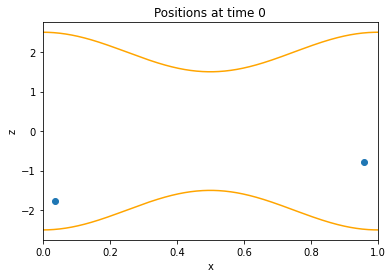

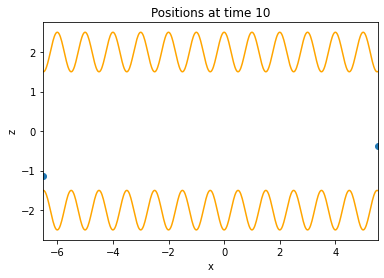

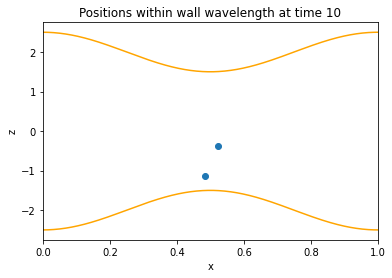

Total number of particles: 2



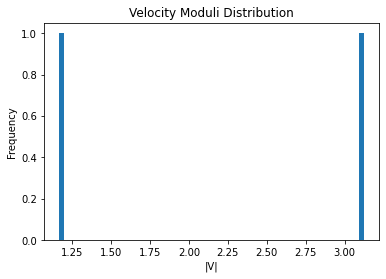


The following plots show the velocity vector components
for all the particle simulations so far, including the latest
1 at different times.


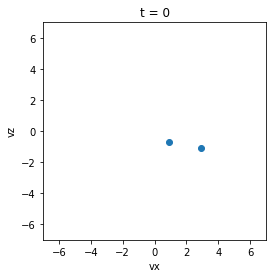

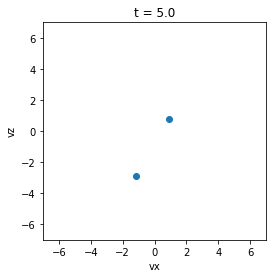

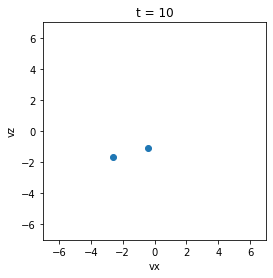

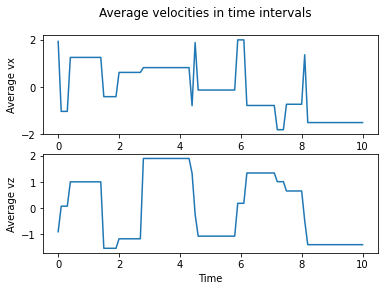

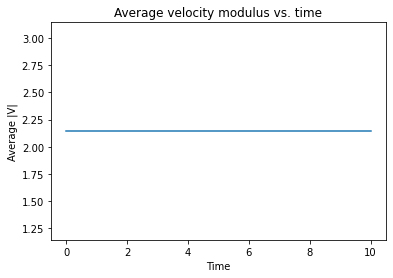

Histogram of average number of single/double/treble/etc-bounce
per particle in this series of simulation runs


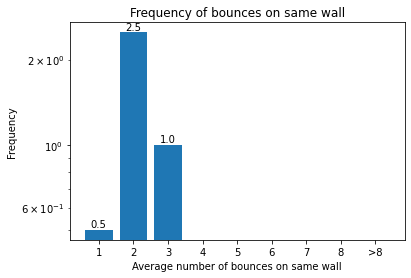

Average number of double- or more multiple bounces per particle
in this series of simulation runs


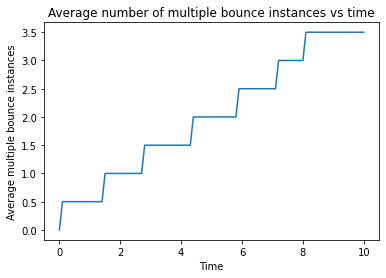

Average number of bounces that are not the first bounce,
per particle, in this series of simulation runs


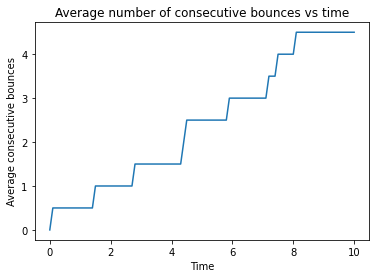

In [ ]:
'''
Main program. 
Initialize main simulation parameters and run main sequence.
Sequence:
    1 - User can update the global simulation variables here if desired, 
    2 - Run the number of simulations in sequence
    3 - Analyse data and visualise the main information of interest
'''

# Lane geometry .
lane_specs = dict(
    wall_wavelength = 1.0,      # In units of length (1.0 for normalized units)
    wall_amplitude = 0.5,       # In units of length
    avg_lane_radius = 2.0         # In units of length
)

# Particle motion initialization specifications.
init_cnsts = dict(
    init_flow_vel = 2.5,        # In units of velocity
    vel_variance = 1.0          # In units of velocity (1.0 for norm. units)
)

# Runtime specifications common to a series of simulations
run_specs = dict(
    single_run_duration = 10,  # In units of time      
    num_time_ints = 100,        # For time analysis of stacked data
    precision = 1e-6,           # In units of length
    num_histogram_bins = 70, 
    num_sim_runs = 1           # Number of particles simulated
)

# Simulation output data file name
sim_data_file = ( "PSR_sim1_runData_" + str(lane_specs["wall_amplitude"])     
           + "_" + str(lane_specs["avg_lane_radius"])                                
           + "_" + str(init_cnsts["init_flow_vel"])                             
           + "_" + str(run_specs["single_run_duration"]) + ".csv" )

# Run the simulations and append results in sim_data_file
simulation_data = run_sims(lane_specs, init_cnsts, run_specs, sim_data_file)

# Display the last particle trajectory as a sample trajectory
plot_last_trajectory(simulation_data, lane_specs, run_specs)

# Stack and analyze simulation data vs. time, plot visualizations
analyze_and_visualize(simulation_data, lane_specs, init_cnsts, run_specs)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
Main code cell. 
'''
###############################################################################
###############################################################################
################################# Sim 1a ######################################
###############################################################################
###############################################################################

# Imports
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt 
from google.colab import drive 
import os
import csv
from datetime import datetime
from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_file, show
from bokeh.models import HoverTool
from bokeh.io import output_notebook

output_notebook()

###############################################################################
# Objects
###############################################################################
'''
Particle object.
Holds all data regarding a particle's position and velocity.
'''
class Particle():

    ###########################################################################

    def __init__(self, x, z, vx, vz, cell=0):
        self.x = x
        self.z = z
        self.vx = vx
        self.vz = vz
        self.cell = cell

    ###########################################################################

    def copy(self):
        return Particle(self.x, self.z, self.vx, self.vz, self.cell)

    ###########################################################################

    def speed(self):
        return np.sqrt(self.vx**2 + self.vz**2)

    ###########################################################################

    def distance(self, x, z):
        return np.sqrt((self.x - x)**2 + (self.z - z)**2)

###############################################################################
# Simulation running and handling
###############################################################################
'''
Function run_sims.
Conducts the main handling of the simulation runs.

Parameters:     
- lane_specs = Constants of the lane geometry.
- init_cnsts = Constants used to give initial position and velocity.
- run_specs = Constants used in running the simulation.

Returns:
- data = The data from the simulation.

Written by Alec Lau in Q3-2020

Last Modified Dec-07, 2020 (Jordan Hoffmann):
- Cleaning code
'''

def run_sims(lane_specs, init_cnsts, run_specs, sim_data_file):
    
    write_file_headings(sim_data_file)

    # Run the simulation for as many particles as specified
    for particle_number in range(0, run_specs["num_sim_runs"]):
        particle_data = simulate_particle(lane_specs, init_cnsts, run_specs)

        write_to_file(particle_data, sim_data_file, particle_number + 1)

    # Read the data from the file it is written into. This is
    # required in case an identical simulation has been previously
    # run and hence we incorporate both sets of data.
    trajectory_data = np.genfromtxt(sim_data_file, delimiter = ",", names =                   
        ["num_cols","time","x","z","vx","vz","cell","date","particle_num"])[1:]

    return trajectory_data

###############################################################################
'''
Function simulate_particle
Simulates the movement of a single particle as a function of time as it
bounces off the walls etc.

Inputs:
- lane_specs = Constants of the geometry of the lane.
- init_cnsts = Constants used to give initial position and velocity.
- run_specs = Constants for the overall simulation running.
- particle_custom (optional) = Custom values for the particle.

Returns:
- num_collisions = Number of times this particle has collided with a wall

Last modified Dec 07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def simulate_particle(lane_specs, init_cnsts, run_specs, 
                      particle_custom = None):

    particle_curr = initialize_particle(lane_specs, init_cnsts, particle_custom)

    num_collisions = 0
        
    # Finding time step to be used          
    time_step = get_time_step(particle_curr, lane_specs)      

    # For error correction:
    prev_x_col = 0.0
    time = run_specs["single_run_duration"]
    init_time = time

    next_row = [num_collisions, 0.0, particle_curr, datetime.now()]
    trajectory_data = [next_row]

    particle_next = particle_curr.copy()

    # Iterate through the particle's path using timesteps and 
    # calculate the position of the particle after each timestep 
    # until the simulation is finished.
    while time > 0:

        # Calculate time step again
        time_step =  get_time_step(particle_curr, lane_specs) 

        # Ensures the final coordinate is recorded
        if time < time_step:
            time_step = time    

        particle_next.x = particle_curr.x + particle_curr.vx*time_step
        particle_next.z = particle_curr.z + particle_curr.vz*time_step

        check_cell(particle_next, lane_specs)
        # Check to see if this step is actually a step over a 
        # wall, and hence a collision
        if abs(particle_next.z) >= wall_func(particle_next.x, lane_specs):
            # Get new coordinates, velocities, and collision
            # coordinates
            particle_next, particle_col, time_col = (collision(lane_specs, 
                            run_specs, particle_curr, time_step, prev_x_col))
            # For error correction
            prev_x_col = particle_col.x
            num_collisions += 1

            # Add this new data to our arrays
            next_row = [num_collisions, init_time-time+time_col, particle_col, 
                        datetime.now()]
            trajectory_data.append(next_row)

            # If it's the remaining time, record where it ends up 
            # instead of where it hits
            if time == time_step:
                next_row = [num_collisions, init_time, particle_next, 
                            datetime.now()]
                trajectory_data.append(next_row)

        elif time == time_step:
            # Record final coordinate if our remaining time is  
            # less than what our calculated time_step would be,  
            # AND if there was no collision.
            next_row = [num_collisions, init_time, particle_next, 
                        datetime.now()]
            trajectory_data.append(next_row)

        else: 
            # Check if the particle is in the central area where there 
            # will be no collisions. If so, skip to the other side.
            if ((abs(particle_curr.z) < (lane_specs["avg_lane_radius"]
                        - lane_specs["wall_amplitude"])) 
                    and ((abs(particle_next.z)) < (abs(particle_curr.z)))):

                # Lower wall to upper wall
                if particle_curr.z < 0:
                    particle_next.z = (lane_specs["avg_lane_radius"]
                                - lane_specs["wall_amplitude"])
                    particle_next.x = ((particle_next.z - particle_curr.z)
                                * particle_next.vx / particle_next.vz 
                                + particle_curr.x)
                    
                # Upper wall to lower wall
                else:
                    particle_next.z = (-lane_specs["avg_lane_radius"]
                                + lane_specs["wall_amplitude"])
                    particle_next.x = ((particle_next.z - particle_curr.z)
                                * particle_curr.vx / particle_curr.vz
                                + particle_curr.x)

                # We now have our new coordinates - we skipped  
                # across the gap to the other side of the tube  
                # now we have to calculate how much time that took
                time_step = (particle_curr.distance(particle_next.x, 
                                particle_next.z) / particle_curr.speed())

                # Check to see if this time difference is larger  
                # than the time left. If so,  travel with time left
                if time_step > time:
                    particle_next.x = (particle_curr.x + particle_curr.vx*time)
                    particle_next.z = (particle_curr.z + particle_curr.vz*time)
                    check_cell(particle_next, lane_specs)
                    next_row = [num_collisions, init_time, particle_next,
                                datetime.now()]
                    trajectory_data.append(next_row)
                    time_step = time
                
                check_cell(particle_next, lane_specs)

        particle_curr = particle_next.copy()

        time -= time_step

    return trajectory_data

###############################################################################
'''
Function get_time_step.
Gets the time step to be used in the numerical iterations.

Inputs:
- speed = Speed of the particle.
- lane_specs = Constants of the lane geometry.

Returns:
- time_step = The calculated time step.

Last modified Dec 07, 2020 (Jordan Hoffmann)
'''

def get_time_step(particle, lane_specs):
    arb_min_speed = 5.0
    arb_scale_factor = 50.0
    time_step =  min(lane_specs["wall_wavelength"]/arb_min_speed,
                     lane_specs["wall_wavelength"]
                     / (particle.speed()*arb_scale_factor))  
    
    return time_step

###############################################################################
'''
Function initialize_particle.                                         
Assigns a random x and z position from a uniform distribution within 
the first one-wavelength cell of the lane. 
Assigns Rayleigh-distributed Vx and Vz velocity components and adds 
on an initial flow rate in the X direction.
Also accepts user-specified positional and velocity components.

Parameters:
- lane_specs = Constants of the lane geometry.
- init_cnsts = Constants used to get the initial position and velocity.
- particle_custom (optional) = Custom values for the particle.

Returns:
- particle = Values for the initial particle

Written by Alec Lau in Q3-2020

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def initialize_particle(lane_specs, init_cnsts, particle_custom = None):
    
    # Check if a custom particle initialization is used
    if particle_custom == None:
        particle = Particle(0,0,0,0)

        # Generate a random X and Z component within the rectangle 
        # completely enclosing the first wavelength, then redo both 
        # components if it lies outside the sinusoidal walls
        lane_diameter = 2*(lane_specs["wall_amplitude"] + 
                       lane_specs["avg_lane_radius"])
        while True:
            # Random X coordinate from a uniform distribution
            particle.x = lane_specs["wall_wavelength"]*np.random.random_sample()

            # Random Z coordinate from a uniform distribution 
            particle.z = lane_diameter*(np.random.random_sample() - 0.5)

            max_z_range = wall_func(particle.x, lane_specs)
            if (np.abs(particle.z) < max_z_range):
                break

        # X and Z components of the velocities have normal distribution with
        # 0 mean and the same variance (input parameter contained in 
        # init_cnsts). The X component then has an initial flow added to it.
        # We loop to ensure the speed is not 0.
        while True:
            particle.vx = (np.random.normal(scale = 
                                        np.sqrt(init_cnsts["vel_variance"]))
                                + init_cnsts["init_flow_vel"])
            particle.vz = np.random.normal(scale = 
                                np.sqrt(init_cnsts["vel_variance"]))

            if np.abs(particle.speed()) > 1e-4:
                break

    else:
        particle = particle_custom.copy()
  
    return particle

###############################################################################
'''
Function wall_func.
Gives the radius of the lane at a particular x coordinate. This is 
necessary as the radius is larger at a sinusoidal 'peak' and smaller at
a sinusoidal 'trough'.

Inputs:
- x = The x coordinate in question.
- lane_specs = Constants of the geometry of the lane.

Returns:
- z = The lane radius at the corresponding x coordinate.

Last modified Dec 07, 2020 (Jordan Hoffmann)
- Cleaning code
'''
def wall_func(x, lane_specs):
    return (lane_specs["avg_lane_radius"] + lane_specs["wall_amplitude"]
           * np.cos(2*np.pi*x/lane_specs["wall_wavelength"]))

###############################################################################
'''
Function collision.
Determines the next collision point coordinates of the particle  
with the sinusoidal walls.

Inputs:
- lane_specs = Constants of the lane geometry.
- run_specs = Constants of the run parameters.
- particle = Particle data before the collision.
- time_step = The time_step of the simulation.
- prev_x_col = The x coordinate of the previous collision point.

Returns:
- particle_after = particle data after collision.
- x_col = The x coordinate of the collision point.
- z_col = The z coordinate of the collision point.
- time_col = The time taken to get to the collision point.

Written by Alec Lau in Q3-2020

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def collision(lane_specs, run_specs, particle, time_step, prev_x_col):

    # Find where the particle hits the wall using scipy's fsolve.
    x_col = 0.0
    z_col = 0.0

    if particle.vx == 0:
        x_col = particle.x
        z_col = particle.z/abs(particle.z) * wall_func(particle.x, lane_specs)
    else:
        # Define the position function given the data. We want to find 
        # when the wall function - position function = 0. x-intersect 
        # is the x coordinate of the intersection (evaluation) point.
        def intersect_top(x):
            return (wall_func(x, lane_specs) - linear(particle.vz/particle.vx, 
                                                    particle.x, particle.z, x))

        # Account for bottom wall too.
        def intersect_bot(x):
            return (-wall_func(x, lane_specs) - linear(particle.vz/particle.vx, 
                                                    particle.x, particle.z, x))
    
        # Check for a collision with the top wall
        if particle.z > 0:
            x_col = (fsolve(intersect_top, particle.x, 
                            xtol = run_specs["precision"])[0])
            if abs(x_col - prev_x_col) < run_specs["precision"]:
                next_x = particle.x + particle.vx * time_step * 1.5
                x_col = fsolve(intersect_top, next_x, 
                               xtol = run_specs["precision"])[0]
                                     
            z_col = wall_func(x_col, lane_specs)

        # Otherwise, collision with the bottom wall
        else:
            x_col = fsolve(intersect_bot, particle.x, 
                           xtol = run_specs["precision"])[0]
            if abs(x_col - prev_x_col) < run_specs["precision"]:
                next_x = particle.x + particle.vx * time_step * 1.5
                x_col = fsolve(intersect_bot, next_x,            
                               xtol = run_specs["precision"])[0]
                                     
            z_col = -wall_func(x_col, lane_specs)

    # We want to bounce the particle off the wall's tangent line at 
    # the collision point.
    tangent_slope = (- lane_specs["wall_amplitude"]
                    * (2*np.pi/lane_specs["wall_wavelength"])
                    * np.sin(2*np.pi*x_col/lane_specs["wall_wavelength"]))

    # This entails us reflecting the velocity about a unit vector normal 
    # to the tangent point thus we need the angle. Since we have the 
    # slope, the angle is arctan of that (arctan(slope)).

    # The change in x of the UNIT tangent vector is then 
    # cos(arctan(slope)), or 1/(1+slope^2). So, the change in x of 
    # the UNIT NORMAL vector is then sin(arctan(slope)), or 
    # slope/(1+slope^2)
    unit_norm_x = tangent_slope / np.sqrt(1 + tangent_slope**2)

    # The change in z of the UNIT tangent vector is then 
    # sin(arctan(slope)), or slope/(1+slope^2). So, the change in z
    # of the UNIT NORMAL vector is then -cos(arctan(slope)), or 
    # -1/(1+slope^2)

    # This was assuming the normal vector will point down, i.e. 
    # rotated the tangent vector at the top wall by -pi/2 radians. 
    # If the particle hits the lower wall, we need to rotate the 
    # tangent vector by +pi/2 radians instead, hence the factor of 
    # z/abs(z) at the end
    unit_norm_z = -1/np.sqrt(1+tangent_slope**2) * particle.z/abs(particle.z)
  
    particle_after = particle.copy()

    # Once we have our unit normal vector N, the formula for the 
    # reflected velocity is -2(N dot V)N - V
    particle_after.vx = (-2*(unit_norm_x*particle.vx + unit_norm_z*particle.vz)
                             *unit_norm_x + particle.vx)
    particle_after.vz = (-2*(unit_norm_x*particle.vx + unit_norm_z*particle.vz)
                             *unit_norm_z + particle.vz)


    # Now we need to find the distance traveled after the collision, 
    # as the collision is in the middle of the current time_step. Take 
    # the distance from the previous point to the collision, divide by 
    # the magnitude of the velocity, and subtract this from the time_step
    time_col = particle.distance(x_col, z_col) / particle.speed()
    time_left = time_step - time_col

    particle_after.x = x_col + particle_after.vx*time_left
    particle_after.z = z_col + particle_after.vz*time_left

    particle_col = particle_after.copy()
    particle_col.x = x_col
    particle_col.z = z_col

    check_cell(particle_after, lane_specs)
    check_cell(particle_col, lane_specs)

    return particle_after, particle_col, time_col
    
###############################################################################
'''
Function check_cell.
Checks that the X coordinate is within one wavelength and if not,
adjusts the cell number and the X coordinate accordingly.

Last modified Dec 16, 2020 (Jordan Hoffmann)
'''

def check_cell(particle, lane_specs):

    if ((particle.x > lane_specs["wall_wavelength"]) or
        (particle.x < 0)):
        new_x = particle.x % lane_specs["wall_wavelength"]
        cell_incr = np.round((particle.x - new_x)
                             /lane_specs["wall_wavelength"])
        particle.x = new_x
        particle.cell += cell_incr

    return

###############################################################################
# File Writing
###############################################################################
'''
Function write_file_headings.
Checks if the simulation file already exists and if not creates it and
adds headings to it.

Parameters:
- sim_data_file = File name to be checked.

Returns:
- None
'''

def write_file_headings(sim_data_file):

    if not os.path.isfile(sim_data_file):                                      
        with open(sim_data_file, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["collision number", "time of collision",          
                             "x-coord", "z-coord", "x-velocity", "z-velocity", 
                             "cell number", "date-time", "particle number"])
        file.close()
        print("File at: " + str(os.path))

    return

##############################################################################
'''
Function write_to_file.
Writes simulation data into an output file.

Parameters:
- data_array = Array of the data to be written.
- sim_data_file = File name to be written to.
- particle_number = Number of the simulated particle.

Returns:
- None.
'''

def write_to_file(data_array, sim_data_file, particle_number):

    with open(sim_data_file, 'a', newline='') as file:
        writer = csv.writer(file)

        for data_point in data_array:
            particle = data_point[2]
            writer.writerow([data_point[0], data_point[1], particle.x, 
                             particle.z, particle.vx, particle.vz,
                             particle.cell, data_point[3], particle_number])

    file.close()

    return

###############################################################################
# Helper functions
###############################################################################
'''
Function linear.
Calculates the z coordinate for a corresponding x coordinate on a 
straight line given the gradient and another point. 
(z = m*(x - x_0) + z_0)

Parameters:
- slope = Gradient of the line (m).
- x_start = The x coordinate of a known point on the line (corr. to z_start).
- z_start = The z coordinate of a known point on the line (corr. to x_start).
- x_end = The x coordinate at which we wish to evaluate the z coordinate.

Returns:
- z_end = The z coordinate of the point corresponding to x_end.

Written by Alec Lau in Q3-2020

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def linear(slope, x_start, z_start, x_end):
    return slope * (x_end - x_start) + z_start


###############################################################################
###############################################################################
################################# Sim 1b ######################################
###############################################################################
###############################################################################
'''
Function plot_last_trajectory.
Creates a plot of the trajectory of a single particle (the last in the file).

Parameters:
- data = The data from the simulation.
- lane_specs = Constants of the lane geometry.
- run_specs = Constants used in the simulation running.

Returns:
- None

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def plot_last_trajectory(data, lane_specs, run_specs):
    index = -1
    for time in reversed(data["time"]):
        if time == 0.0:
            break
        index -= 1

    print("You are simulating the trajectory of "
          + str(run_specs["num_sim_runs"]) + " non-interacting particles.")
    print("Wall wavelength: " + str(lane_specs["wall_wavelength"])
          + " & amplitude: " + str(lane_specs["wall_amplitude"]))
    print("Wall sinusoidal amplitude: " + str(lane_specs["wall_amplitude"])
          + " units of length")
    print("Lane average half-radius: " + str(lane_specs["avg_lane_radius"])
          + " units of length")
    print("Simulation run duration: " + str(run_specs["single_run_duration"])
          + " units of time")
    print("Initial flow velocity: " + str(init_cnsts["init_flow_vel"])
          + " units of velocity")
    print()
    print("Last particle:")
    print("===============")
    print("Initial coordinates: " + str(data["x"][index]) + ", " 
          + str(data["z"][index]))
    print("Initial velocity: " + str(data["vx"][index]) + ", "
          + str(data["vz"][index]))
    print("Initial velocity modulus: "+str(np.sqrt(data["vx"][index]**2
          + data["vz"][index]**2)))
    print("Number of collisions: " + str(int(data["num_cols"][-1])))
    print("Final coordinates: " + str(data["x"][-1] 
          + data["cell"][-1]*lane_specs["wall_wavelength"]) + ", "
          + str(data["z"][-1]))
    print("Final velocity: " + str(data["vx"][-1]) + ", "
          + str(data["vz"][-1]))
    print("Final velocity modulus: " + str(np.sqrt(data["vx"][-1]**2
          + data["vz"][-1]**2)))

    x_cell = [x*lane_specs["wall_wavelength"] for x in data["cell"][index:]]
    x_array = np.add(data["x"][index:], x_cell)
    z_array = data["z"][index:]
    x_max = np.amax(x_array)
    x_min = np.amin(x_array)
    x_abs_max = max(x_max, x_min + 30*lane_specs["wall_wavelength"])
    x_coords = np.linspace(x_min, x_abs_max, max(10000,len(x_array)))

    TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select,hover"
    p1 = figure(title = "Example trajectory: very last particle in this set "
                + "of simulation runs:", tools = TOOLS, plot_width = 1000,
                plot_height = 400)

    p1.line(x_array, z_array, color = "blue")
    p1.line(x_coords, wall_func(x_coords, lane_specs), color = "orange")
    p1.line(x_coords, -wall_func(x_coords, lane_specs), color = "orange")
    source = dict(
        hover_x = x_array,
        hover_z = z_array
    )

    p1.add_tools(HoverTool(tooltips=[("(x,y)", "($hover_x, $hover_z)")]))
    show(p1)

    return

###############################################################################
'''
Function analyze_and_visualize.
Analyzes the code and produces visualizations of the results

Parameters:
- data = The data from the simulation conducted.
- lane_specs = Constants of the lane geometry.
- init_cnsts = Constants used to get the initial position and velocity.
- run_specs = Constants for the simulation running.

Returns:
- None

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def analyze_and_visualize(data, lane_specs, init_cnsts, run_specs):
    avg_vx, avg_vz, avg_moduli, time_coords, num_sims = (
                                        get_avg_velocities(data, run_specs))

    analysis_data_file = ("PSR_sim1_analysis_" 
                + str(lane_specs["wall_amplitude"]) + "_" 
                + str(lane_specs["avg_lane_radius"]) + "_"
                + str(init_cnsts["init_flow_vel"])+ "_" 
                + str(run_specs["single_run_duration"]) + ".csv")
    write_analysis_file(analysis_data_file, num_sims, time_coords, 
                        avg_vx, avg_vz)

    print("\nThe following plots pertain to all of the runs done for this\n"
        + "set of simulation parameters (lane geometry & particle "
        + "initialization),\n including the latest "
        + str(run_specs["num_sim_runs"]) + " particles.")
    print("Total number of particles: " + str(num_sims))
    
    # Plot initial positions.
    plot_positions(data, 0, lane_specs) 
    # Plot final positions.                                     
    plot_positions(data, run_specs["single_run_duration"], lane_specs)
    # Plot final positions relative to a wavelength.
    plot_positions(data, run_specs["single_run_duration"], lane_specs,
                   lane_specs["wall_wavelength"])   
      
    print("Total number of particles: " + str(num_sims) + "\n")
    # Plot speeds as a histogram.
    plot_velocity_moduli(data, run_specs["num_histogram_bins"])

    print("\nThe following plots show the velocity vector components\n"
        + "for all the particle simulations so far, including the latest\n"
        + str(run_specs["num_sim_runs"]) + " at different times.")
    
    # Plot initial velocity distribution.
    plot_velocity(data, 0, init_cnsts)
    # Plot intermediate velocity distribution.
    plot_velocity(data, run_specs["single_run_duration"]/2, init_cnsts)
    # Plot final velocity distribution.
    plot_velocity(data, run_specs["single_run_duration"], init_cnsts)
    # Plot average velocities as a function of time.
    plot_avg_velocities(time_coords, avg_vx, avg_vz, avg_moduli)
    # Plot the number of bounces as a histogram.
    plot_bounces(data, run_specs["single_run_duration"], run_specs)

    return

###############################################################################
'''
Function get_avg_velocities.
Processes the data to get the average velocities of all the particles
at each time increment.

Parameters:
- data = The data from the simulation.
- run_specs = Constants for the simulation running.

Returns:
- avg_vx = Array containing the average x velocity at each time step.
- avg_vz = Same as above for the z velocity.
- avg_moduli = Same as above for the velocity modulus
- time_coords = Array containing the times of evaluation for the above.
- num_sims = The number of simulations (particles) conducted.
'''

def get_avg_velocities(data, run_specs):
    num_sims = 0
    time = run_specs["single_run_duration"]
    avg_vx = np.zeros(run_specs["num_time_ints"]+1)
    avg_vz = np.zeros(run_specs["num_time_ints"]+1)
    avg_moduli = np.zeros(run_specs["num_time_ints"]+1)
    interval_idx = 0
    time_interval = time/run_specs["num_time_ints"]

    for index in range(0, len(data["time"])):
        time_curr = data["time"][index]
        if time_curr == 0:
            num_sims += 1
            interval_idx = 0
        else:
            while interval_idx*time_interval <= time_curr:
                avg_vx[interval_idx] += data["vx"][index-1]
                avg_vz[interval_idx] += data["vz"][index-1]
                avg_moduli[interval_idx] += (np.sqrt(data["vx"][index-1]**2
                                            + data["vz"][index-1]**2))
                interval_idx += 1

    avg_vx /= num_sims
    avg_vz /= num_sims
    avg_moduli /= num_sims
    time_coords = np.linspace(0.0, time, run_specs["num_time_ints"]+1)

    return avg_vx, avg_vz, avg_moduli, time_coords, num_sims

###############################################################################
'''
Function write_analysis_file.
Write the data of the average velocities to an analysis file.

Parameters:
- analysis_data_file = File name to be written to.
- num_sims = The number of simulations (particles) conducted.
- time_coords = Array containing the times of evaluation for the above.
- avg_vx = Array containing the average x velocity at each time step.
- avg_vz = Same as above for the z velocity.

Returns:
- None
'''

def write_analysis_file(analysis_data_file, num_sims, time_coords, 
                        avg_vx, avg_vz):
    if os.path.isfile(analysis_data_file):
        os.remove(analysis_data_file)

    with open(analysis_data_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Total number of particles:", num_sims])       
        writer.writerow(["Time", "Average vx", "Average vz"])
        for idx in range(0, len(time_coords)):
            writer.writerow([time_coords[idx], avg_vx[idx], avg_vz[idx]])
        file.close()

    return

###############################################################################
'''
Function plot_velocity_moduli.
Plots the modulus of the particles' velocities as a histogram.

Parameters:
- data = The data to be plotted.
- bin_number = The number of bins to be used in the histogram.

Returns:
- None

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def plot_velocity_moduli(data, bin_number):
    moduli = []
    index = 0
    for i in data["num_cols"]:
        if i == 0:
            moduli.append(np.sqrt(data["vx"][index]**2 + data["vz"][index]**2))
        index += 1

    plt.hist(moduli, bins = bin_number)
    plt.xlabel("|V|")
    plt.ylabel("Frequency")
    plt.title("Velocity Moduli Distribution")
    plt.show()

    return

###############################################################################
'''
Function plot_positions.
Plots the positions of all particles at a specified time.

Parameters:
- data = The data from the simulation.
- time = Time at which the 'snapshot' is taken.
- lane_specs = Constants of the lane geometry.
- domain (optional) = By default everything. If given a value, finds
    the positions in some repeating domain, e.g. how the positions
    are situated in one wavelength.

Returns:
- None

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
- Combining plot_positions and plot_positions_in_domain
'''

def plot_positions(data, time, lane_specs, domain = None):
    x, z = give_positions(data, time, lane_specs)

    # Check if a domain is given
    if domain != None:
        title = "Positions within wall wavelength at time " + str(time)
        for i in range(0, len(x)):
            x[i] = x[i] % domain

        x_min = 0
        x_max = domain
    else:
        title = "Positions at time " + str(time)

        x_min = np.amin(x)
        x_max = np.amax(x)
        if x_min > 0:
            x_min = 0
        if x_max < lane_specs["wall_wavelength"]:
            x_max = lane_specs["wall_wavelength"]

    plt.scatter(x, z)
    # Ensure that at least min_pts_per_wavelength points per
    # wavelength are plotted.
    min_pts_per_wavelength = 10
    num_points = int(round(min_pts_per_wavelength * (x_max - x_min)
                           / lane_specs["wall_wavelength"]))
    wall_coords = np.linspace(x_min, x_max, max(500, num_points))
    plt.plot(wall_coords, wall_func(wall_coords, lane_specs), color="orange")
    plt.plot(wall_coords, -wall_func(wall_coords, lane_specs), color="orange")
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(title)
    plt.xlim([x_min, x_max])
    plt.show()

    return

###############################################################################
'''
Function give_positions.
Finds the positions of each of the particles at a specified time.

Parameters:
- data = The data to be analyzed (from the simulation).
- time = The time at which the particles' position is to be found

Returns:
- x = All of the x positions of the particles at the given time.
- z = All of the z positions of the particles at the given time.

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def give_positions(data, time, lane_specs):
    x = []
    z = []
    index = 0
    for i in data["time"]:
        if i == time:
            x.append(data["x"][index] + data["cell"][index]
                     *lane_specs["wall_wavelength"])
            z.append(data["z"][index])
        index += 1

    return x, z

###############################################################################
'''
Function plot_velocity.
Plots the velocities of all particles at a given time. The velocities 
are decomposed into their x and z components and then these are 
plotted as a scatter plot.

Parameters:
- data = The data from the simulation.
- time = The time at which we are taking the 'snapshot'.
- init_cnsts = Constants used to give the initial positions and 
  velocities.

Returns:
- None

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def plot_velocity(data, time, init_cnsts):
    vx = []
    vz = []
    for index in range(0, len(data["time"]) - 1):
        time_curr = data["time"][index]
        timeNext = data["time"][index+1]
        if (time >= time_curr) and (timeNext >= time):
            vx.append(data["vx"][index])
            vz.append(data["vz"][index])
    
    # Below ensures the scaling of the three scatter plots are the same:
    max_c = np.ceil(init_cnsts["init_flow_vel"] + 4*init_cnsts["vel_variance"])
    min_c = -1*max_c
    plt.figure(figsize=(4,4))
    plt.scatter(vx, vz)
    plt.xlabel("vx"), plt.ylabel("vz")
    plt.xlim(min_c, max_c), plt.ylim(min_c, max_c)
    plt.title("t = " + str(time))
    plt.show()

    return

###############################################################################
'''
Function plot_avg_velocities.
Plots the average velocities of all particles as a function of time.

Parameters:
- time_coords = Array of the times at which each event occurs.
- avg_vx = Array of the average x velocity of all particles at each time.
- avg_vz = Same as above for z velocities.
- avg_moduli = Same as above for the velocity modulus.

Returns:
- None

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def plot_avg_velocities(time_coords, avg_vx, avg_vz, avg_moduli): 
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle("Average velocities in time intervals")
    ax2.set(xlabel = "Time")
    ax1.set(ylabel = "Average vx"), ax2.set(ylabel = "Average vz")                           
    ax1.plot(time_coords, avg_vx)
    ax2.plot(time_coords, avg_vz)
    plt.show(fig)

    plt.plot(time_coords, avg_moduli)
    plt.xlabel("Time")
    plt.ylabel("Average |V|")
    plt.title("Average velocity modulus vs. time")
    plt.ylim(avg_moduli[0] - 1, avg_moduli[0] + 1)
    plt.show()

    return

###############################################################################
'''
Function plot_bounces.
Plots the number of bounces on a consecutive wall as a histogram.

Parameters:
- data = Data from the simulation.
- time = Maximum time for which the simulation runs.
- run_specs = Constants used in the simulation running.

Returns:
- None

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def plot_bounces(data, time, run_specs):
    num_sims = 0
    num_clumps = 0  # Number of instances where the particle hits the  
                    # same wall >= twice (clumps of consecutive bounces)
    num_repeat_bounces = 0  # Number of consecutive bounces
    sim_idx = 0
    bounces_histogram = np.zeros(9)
    avg_num_consecutive_bounces = np.zeros(run_specs["num_time_ints"] + 1)
    avg_num_clumps = np.zeros(run_specs["num_time_ints"] + 1)
    interval_idx = 0
    nth_bounce = 1
    sign = 0
    prev_sign = 0

    for sim_idx in range(0, len(data["time"])):
        time_curr = data["time"][sim_idx]
        # Ensure we're getting coordinates of a collision
        if time_curr != 0:
      
            # Determine if consecutive bounce or not
            if data["z"][sim_idx] < 0.0:
                sign = -1
            else:
                sign = 1
      
            if (prev_sign == sign) and (time_curr != time):
                nth_bounce += 1
                if nth_bounce == 2:
                    num_clumps += 1
                num_repeat_bounces += 1
            # Special case for the first collision
            elif nth_bounce == 0:
                nth_bounce = 1
            else:
                # add data to histogram
                if nth_bounce > 8:
                    bounces_histogram[-1] += 1
                else:
                    bounces_histogram[nth_bounce-1] += 1
                    nth_bounce = 1

            prev_sign = sign
            while interval_idx*time/run_specs["num_time_ints"] <= time_curr:
                avg_num_clumps[interval_idx] += num_clumps
                avg_num_consecutive_bounces[interval_idx] += num_repeat_bounces
                interval_idx += 1

        # Time edge cases (t=0, t=T)
        elif time_curr == 0:
            nth_bounce = 0
            interval_idx = 0
            num_clumps = 0
            num_repeat_bounces = 0
            sign = 0
            prev_sign = 0
            num_sims += 1
        else:
            if num_repeat_bounces > 1000:   
                break
            while interval_idx*time/run_specs["num_time_ints"] <= time_curr:
                avg_num_clumps[interval_idx] += num_clumps
                avg_num_consecutive_bounces[interval_idx] += num_repeat_bounces
                interval_idx += 1
  
    # Plotting histogram
    bounces_histogram /= num_sims
    x = ['1', '2', '3', '4', '5', '6', '7', '8', '>8']

    fig, ax = plt.subplots()                                                    
    chart = ax.bar(x, bounces_histogram)
    ax.set_xlabel("Average number of bounces on same wall")
    ax.set_ylabel("Frequency")
    ax.set_title("Frequency of bounces on same wall")
    ax.set_xticklabels(x)
    ax.set_yscale('log')
    for rect in chart:
        height = rect.get_height()
        if height != 0:
            ax.annotate('{}'.format(round(height, 4)),
                        xy = (rect.get_x() + rect.get_width() / 2, height),
                        xytext = (0, 0.5),
                        textcoords = "offset points",
                        ha = 'center', va = 'bottom')
    print("Histogram of average number of single/double/treble/etc-bounce")
    print("per particle in this series of simulation runs")
    plt.show()

    # Now plotting average number of multiple bounce clumps vs time               
    avg_num_clumps /= num_sims
    time_coords = np.linspace(0.0, time, run_specs["num_time_ints"] + 1)
    plt.title("Average number of multiple bounce instances vs time")
    plt.xlabel("Time")
    plt.ylabel("Average multiple bounce instances")
    plt.plot(time_coords, avg_num_clumps)
    print("Average number of double- or more multiple bounces per particle")
    print("in this series of simulation runs")
    plt.show()

    # Now plotting average number of consecutive bounces vs time
    avg_num_consecutive_bounces /= num_sims
    plt.title("Average number of consecutive bounces vs time")
    plt.xlabel("Time")
    plt.ylabel("Average consecutive bounces")
    plt.plot(time_coords, avg_num_consecutive_bounces)
    print("Average number of bounces that are not the first bounce,")
    print("per particle, in this series of simulation runs")

    return

###############################################################################